# Clustering in PySpark using k-means

Following notebook showcases the flow of a clustering exercise using customer sales data.

<b>The goal of this exercise is to group customers into *n* distinct clusters basis their sales activity and demographics data.</b>

It covers following steps:
- Conversion of input sales data to a feature dataset that can be used for clustering
- Performing clustering
- Profiling the clusters, and
- Setting up a regular scoring process to assign cluster labels basis new sales data.

***

<b>Spark 3.1.2</b> (with Python 3.8) has been used for this notebook.<br>
Refer to [spark documentation](https://spark.apache.org/docs/3.1.2/api/sql/index.html) for help with <b>data ops functions</b>.<br>
Refer to [this article](https://medium.com/analytics-vidhya/installing-and-using-pyspark-on-windows-machine-59c2d64af76e) to <b>install and use PySpark on Windows machine</b>.

***

<mark><b>Note</b></mark>: We are dealing with a sample dataset in this exercise and hence I have freely used `.show()`, `.count()`, `.collect()` actions on the dataframes. Please be careful with such steps on actual datasets.

# 1. Feature dataset creation
We will explore the input transactional datasets and convert them to a customer level features dataset that can be used for the clustering exercise.

<mark>Note</mark>: It's likely that the input transactional and other data that you want to use resides in a SQL database.<br> You can either connect your python code to the SQL database using relevant drivers/code and do the feature set creation in python/spark, or preferably,<br> create the feature dataset in SQL and directly import it for clustering in python/spark.

In [1]:
#importing python packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
pd.set_option("display.float_format", '{:,.2f}'.format)

In [3]:
# spark libs
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [4]:
from helper_fn import group_by_and_rename

<b>Once you have initiated spark session using below command, you can go to [localhost:4040](http://localhost:4040) for the Spark UI to monitor your session.</b>

In [5]:
#initiating spark session
# spark = SparkSession.builder.appName('cluster').getOrCreate()
sc.stop()

spark = SparkSession \
    .builder \
    .appName("cluster") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

In [6]:
def show_null_count(df):
    df_null = df.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for c in df.columns]).toPandas().T
    df_null = df_null.sort_values(by=0,ascending=False)
    return df_null

## Input data

<b>Read all input datasets</b>

In [7]:
df_sales = spark.read.csv('./data/clustering_sales.csv',inferSchema=True,header=True)
df_customer = spark.read.csv('./data/clustering_customer.csv',inferSchema=True,header=True)
df_product = spark.read.csv('./data/clustering_product.csv',inferSchema=True,header=True)
df_payment = spark.read.csv('./data/clustering_payment.csv',inferSchema=True,header=True)

<b>Quick exploration of the datasets:</b>
1. We have sales data that captures date, customer id, product, quantity, dollar amount & payment type at order x item level. `order_item_id` refers to each unique product in each order
2. We have corresponding dimension tables for customer info, product info, and payment tender info

In [8]:
df_sales.show(5)

+--------+-------------+----------+-----------+-------+---+----------+---------------+
|order_id|order_item_id|   tran_dt|customer_id|dollars|qty|product_id|payment_type_id|
+--------+-------------+----------+-----------+-------+---+----------+---------------+
|       1|            1|2020-01-01|        572|    550|  1|        20|              2|
|       2|            2|2020-01-01|        532|    630|  3|        11|              2|
|       3|            3|2020-01-01|        608|    450|  2|        18|              4|
|       4|            4|2020-01-01|        424|    110|  2|        10|              2|
|       5|            5|2020-01-01|        584|    250|  1|         8|              4|
+--------+-------------+----------+-----------+-------+---+----------+---------------+
only showing top 5 rows



In [9]:
# order_item_id is the primary key
(df_sales.count(),
 df_sales.selectExpr('count(Distinct order_item_id)').collect()[0][0],
 df_sales.selectExpr('count(Distinct order_id)').collect()[0][0])

(10000, 10000, 9811)

In [10]:
df_sales.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- tran_dt: string (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- dollars: integer (nullable = true)
 |-- qty: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- payment_type_id: integer (nullable = true)



In [11]:
df_customer.show(5)

+-----------+---+---------+------------+----------------+
|customer_id|age|hh_income|omni_shopper|email_subscribed|
+-----------+---+---------+------------+----------------+
|          1| 46|   640000|           0|               0|
|          2| 32|   890000|           1|               1|
|          3| 45|   772000|           0|               0|
|          4| 46|   303000|           0|               1|
|          5| 38|   412000|           0|               0|
+-----------+---+---------+------------+----------------+
only showing top 5 rows



In [12]:
# we have 1k unique customers in sales data with all their info in customer dimension table
(df_sales.selectExpr('count(Distinct customer_id)').collect()[0][0],
 df_customer.count(),
 df_customer.selectExpr('count(Distinct customer_id)').collect()[0][0])

(1000, 1000, 1000)

In [13]:
# product dimension table provides category and price for each product
df_product.show(5)

+----------+--------+-----+
|product_id|category|price|
+----------+--------+-----+
|         1|       A|  450|
|         2|       B|   80|
|         3|       C|  250|
|         4|       D|  400|
|         5|       E|   50|
+----------+--------+-----+
only showing top 5 rows



In [14]:
(df_product.count(),
 df_product.selectExpr('count(Distinct product_id)').collect()[0][0])

(22, 22)

In [15]:
# payment type table maps the payment type id from sales table
df_payment.show(5)

+---------------+------------+
|payment_type_id|payment_type|
+---------------+------------+
|              1|        cash|
|              2| credit card|
|              3|  debit card|
|              4|   gift card|
|              5|      others|
+---------------+------------+



## Features dataset
The goal of this exercise is to group customers into *n* distinct clusters basis their sales activity and demographics data.

In order to cluster customers, we will require a dataset that summarizes their activity over time into a customer id level dataset, i.e. <b>we need to depict each customer using 1 row for data that covers everything we know about the customer</b>.

The required output table should have 1 row per customer with relevant information as feature columns. There are many possible features that you can create here, some as simple as *sales $ for 1 year*, and some complicated or derived such as *quarterly change in sales of a customer for a particular product category*.

This step of the process will involve conversations with the business stakeholders to determine what features matter to the business.

<b>Features we will be creating for current exercise are listed below</b>

Data we have is for the calendar year 2020 and we will take the whole time frame.<br>
<mark>In your case, you might have to add relevant filters and join the sales dataset with some other datasets to get the required data that can then be aggregated to get below features.</mark>

Overall level:
1. Sales
2. Quantity
3. No. of orders
4. Avg. order value
5. Units per transaction
6. Avg. unit revenue
7. No. of different products bought
8. No. of different product categories bought
9. No. of different payment types used

Category level:
1. Split of category level sales as % of total sales
2. Split of category level units as % of total units

Tender type level:
1. Split of tender type level sales as % of total sales

Customer information:
1. Omni shopper flag
2. Email subscription flag
Other demographics data will be kept only for profiling.

### Overall level features

In [16]:
df_sales = df_sales.join(df_product.select('product_id','category'), on=['product_id'], how='left')
df_sales = df_sales.join(df_payment, on=['payment_type_id'], how='left')

In [17]:
df_sales.show(5)

+---------------+----------+--------+-------------+----------+-----------+-------+---+--------+------------+
|payment_type_id|product_id|order_id|order_item_id|   tran_dt|customer_id|dollars|qty|category|payment_type|
+---------------+----------+--------+-------------+----------+-----------+-------+---+--------+------------+
|              2|        20|       1|            1|2020-01-01|        572|    550|  1|       D| credit card|
|              2|        11|       2|            2|2020-01-01|        532|    630|  3|       A| credit card|
|              4|        18|       3|            3|2020-01-01|        608|    450|  2|       C|   gift card|
|              2|        10|       4|            4|2020-01-01|        424|    110|  2|       E| credit card|
|              4|         8|       5|            5|2020-01-01|        584|    250|  1|       C|   gift card|
+---------------+----------+--------+-------------+----------+-----------+-------+---+--------+------------+
only showing top 5 

In [18]:
# aggregate
df_features_overall = df_sales.groupby(['customer_id']).agg(
    F.sum('dollars').alias('sales'),
    F.sum('qty').alias('qty'),
    F.countDistinct('order_id').alias('orders'),
    F.countDistinct('product_id').alias('unique_products_bought'),
    F.countDistinct('payment_type_id').alias('unique_payments_used'),
    F.countDistinct('category').alias('unique_categories_bought'))

In [19]:
# derived vars
df_features_overall = df_features_overall.withColumn('aov',F.col('sales')/F.col('orders'))
df_features_overall = df_features_overall.withColumn('aur',F.col('sales')/F.col('qty'))
df_features_overall = df_features_overall.withColumn('upt',F.col('qty')/F.col('orders'))

In [20]:
df_features_overall.show(5)

+-----------+-----+---+------+----------------------+--------------------+------------------------+------------------+------------------+------------------+
|customer_id|sales|qty|orders|unique_products_bought|unique_payments_used|unique_categories_bought|               aov|               aur|               upt|
+-----------+-----+---+------+----------------------+--------------------+------------------------+------------------+------------------+------------------+
|        496|10235| 46|    21|                    15|                   4|                       5| 487.3809523809524|             222.5|2.1904761904761907|
|        833| 6005| 17|     7|                     7|                   3|                       4| 857.8571428571429| 353.2352941176471|2.4285714285714284|
|        148|13535| 50|    21|                    14|                   5|                       5| 644.5238095238095|             270.7| 2.380952380952381|
|        463| 8685| 41|    23|                    17|     

### Category level features
<b>Sales & Units</b>

In [21]:
df_category_features = df_sales.groupby('customer_id','category').agg(
    F.sum('dollars').alias('dollars'),
    F.sum('qty').alias('units'))

In [22]:
# add overall sales
df_category_features = df_category_features.join(
    df_features_overall.select('customer_id','sales','qty'),
    on=['customer_id'],
    how='left')

In [23]:
# convert to %
df_category_features = df_category_features.withColumn(
    'sales_perc',
    F.col('dollars')/F.col('sales'))
df_category_features = df_category_features.withColumn(
    'units_perc',
    F.col('units')/F.col('qty'))

In [24]:
df_category_features.show(5)

+-----------+--------+-------+-----+-----+---+-------------------+----------+
|customer_id|category|dollars|units|sales|qty|         sales_perc|units_perc|
+-----------+--------+-------+-----+-----+---+-------------------+----------+
|        148|       A|   8660|   21|13535| 50| 0.6398226819357222|      0.42|
|        148|       E|    260|    5|13535| 50|0.01920945696342815|       0.1|
|        148|       C|   1450|    6|13535| 50|0.10712966383450313|      0.12|
|        148|       B|   1815|   15|13535| 50|0.13409678611008496|       0.3|
|        148|       D|   1350|    3|13535| 50|0.09974141115626155|      0.06|
+-----------+--------+-------+-----+-----+---+-------------------+----------+
only showing top 5 rows



In [25]:
# pivot
df_category_features = df_category_features.groupby('customer_id').pivot('category').agg(
    F.max('sales_perc').alias('cat_sales'),
    F.max('units_perc').alias('cat_units'))

### Tender type level

In [26]:
df_payment_features = df_sales.groupby('customer_id','payment_type').agg(F.sum('dollars').alias('dollars'))

In [27]:
# add overall sales
df_payment_features = df_payment_features.join(
    df_features_overall.select('customer_id','sales'),
    on=['customer_id'],
    how='left')

In [28]:
# convert to %
df_payment_features = df_payment_features.withColumn(
    'sales_perc',
    F.col('dollars')/F.col('sales'))

In [29]:
df_payment_features.show(5)

+-----------+------------+-------+-----+--------------------+
|customer_id|payment_type|dollars|sales|          sales_perc|
+-----------+------------+-------+-----+--------------------+
|        148|   gift card|   1350|13535| 0.09974141115626155|
|        148| credit card|   7595|13535|  0.5611377909124492|
|        148|        cash|    150|13535|0.011082379017362394|
|        148|  debit card|   3090|13535| 0.22829700775766532|
|        148|      others|   1350|13535| 0.09974141115626155|
+-----------+------------+-------+-----+--------------------+
only showing top 5 rows



In [30]:
# clean-up values in payment type column
df_payment_features = df_payment_features.withColumn(
    'payment_type',
    F.concat(F.lit('pay_'), F.regexp_replace(F.col('payment_type'),' ','_')))

In [31]:
# pivot
df_payment_features = df_payment_features.groupby('customer_id').pivot('payment_type').agg(
    F.max('sales_perc'))

In [32]:
df_payment_features.show(5)

+-----------+--------------------+-------------------+-------------------+--------------------+-------------------+
|customer_id|            pay_cash|    pay_credit_card|     pay_debit_card|       pay_gift_card|         pay_others|
+-----------+--------------------+-------------------+-------------------+--------------------+-------------------+
|        148|0.011082379017362394| 0.5611377909124492|0.22829700775766532| 0.09974141115626155|0.09974141115626155|
|        463| 0.05181347150259067| 0.5808865860679332| 0.2515831894070236|  0.1157167530224525|               null|
|        471|                null|0.22026431718061673| 0.7268722466960352|                null|0.05286343612334802|
|        496|                null| 0.7054225696140694|0.15828041035661944|   0.063019052271617|0.07327796775769418|
|        833|                null| 0.3871773522064946| 0.5995004163197336|0.013322231473771857|               null|
+-----------+--------------------+-------------------+------------------

### Final Features dataset

In [33]:
df_features = df_features_overall.join(df_category_features,on=['customer_id'],how='left')

df_features = df_features.join(df_payment_features,on=['customer_id'],how='left')

df_features = df_features.join(
    df_customer.select('customer_id','email_subscribed','omni_shopper'),
    on=['customer_id'],
    how='left')

In [34]:
# persist this df to break lineage
# our data is small and hence reducing partitions to 10; for actual data, be careful with this step
df_features = df_features.repartition(10).persist()
df_features.count()

1000

In [35]:
df_features.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- sales: long (nullable = true)
 |-- qty: long (nullable = true)
 |-- orders: long (nullable = false)
 |-- unique_products_bought: long (nullable = false)
 |-- unique_payments_used: long (nullable = false)
 |-- unique_categories_bought: long (nullable = false)
 |-- aov: double (nullable = true)
 |-- aur: double (nullable = true)
 |-- upt: double (nullable = true)
 |-- A_cat_sales: double (nullable = true)
 |-- A_cat_units: double (nullable = true)
 |-- B_cat_sales: double (nullable = true)
 |-- B_cat_units: double (nullable = true)
 |-- C_cat_sales: double (nullable = true)
 |-- C_cat_units: double (nullable = true)
 |-- D_cat_sales: double (nullable = true)
 |-- D_cat_units: double (nullable = true)
 |-- E_cat_sales: double (nullable = true)
 |-- E_cat_units: double (nullable = true)
 |-- pay_cash: double (nullable = true)
 |-- pay_credit_card: double (nullable = true)
 |-- pay_debit_card: double (nullable = true)
 |-- pay_gift_card:

In [36]:
df_features.write.parquet('./data/clustering_features/', mode='overwrite')

# 2. k-means clustering

In [37]:
df_features = spark.read.parquet('./data/clustering_features/')

## Summary of features

- There are nulls in category and payment % split features: fill with 0

In [38]:
# taking summary only for few columns. For all columns, it would be preferable to save the summary output to file
# instead of printing the output
df_features.select('sales','qty','orders','aov','aur','upt').summary().show()

+-------+-----------------+-----------------+-----------------+------------------+------------------+-------------------+
|summary|            sales|              qty|           orders|               aov|               aur|                upt|
+-------+-----------------+-----------------+-----------------+------------------+------------------+-------------------+
|  count|             1000|             1000|             1000|              1000|              1000|               1000|
|   mean|          5707.17|           21.108|            9.811|  575.336384169622| 271.1505304804412| 2.1246893920819834|
| stddev|4036.079859434367|14.40839817391017|6.384986064749635|165.74126736003032|  65.9414953443109|0.34400733385649096|
|    min|              330|                3|                3|             110.0|              60.0|                1.0|
|    25%|             2805|               11|                5|             467.5|             227.5|                1.9|
|    50%|             42

In [39]:
# converting summary o/p to pandas
df_features.summary().toPandas().set_index('summary').T.astype('float')

summary,count,mean,stddev,min,25%,50%,75%,max
customer_id,"1,000.00",500.50,288.82,1.00,250.00,500.00,750.00,"1,000.00"
sales,"1,000.00","5,707.17","4,036.08",330.00,"2,805.00","4,280.00","7,260.00","17,635.00"
qty,"1,000.00",21.11,14.41,3.00,11.00,16.00,23.00,58.00
orders,"1,000.00",9.81,6.38,3.00,5.00,8.00,10.00,24.00
unique_products_bought,"1,000.00",7.55,3.85,2.00,5.00,6.00,9.00,18.00
unique_payments_used,"1,000.00",3.00,0.95,1.00,2.00,3.00,4.00,5.00
unique_categories_bought,"1,000.00",3.84,1.01,1.00,3.00,4.00,5.00,5.00
aov,"1,000.00",575.34,165.74,110.00,467.50,568.00,669.76,"1,202.50"
aur,"1,000.00",271.15,65.94,60.00,227.50,267.89,311.22,485.00
upt,"1,000.00",2.12,0.34,1.00,1.90,2.14,2.33,3.67


In [40]:
show_null_count(df_features)

,0
pay_others,744
pay_cash,737
pay_gift_card,366
E_cat_units,329
E_cat_sales,329
D_cat_sales,322
D_cat_units,322
B_cat_units,246
B_cat_sales,246
C_cat_sales,171


In [41]:
# all the features we have can be filled with 0
df_features = df_features.fillna(0)

## Vector assembly
Spark algos require features in the Vector form

In [42]:
from pyspark.ml.feature import VectorAssembler

In [43]:
# we will ignore customer_id col
df_cols = df_features.drop('customer_id').columns

In [44]:
vec_assembler = VectorAssembler(inputCols = df_cols, outputCol='features')
df = vec_assembler.transform(df_features)

In [45]:
# save assembler
vec_assembler.write().overwrite().save('./files/model_objects/vec_assemblor/')

In [46]:
# keep only req. cols for model
df = df.select('customer_id','features')

## Feature scaling

- We will use MinMaxScaler

In [47]:
from pyspark.ml.feature import MinMaxScaler

In [48]:
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

In [49]:
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

In [50]:
df.show(5)

+-----------+--------------------+--------------------+
|customer_id|            features|      scaledFeatures|
+-----------+--------------------+--------------------+
|        737|[14540.0,49.0,21....|[0.82114995665992...|
|         31|[3870.0,15.0,7.0,...|[0.20456515457960...|
|         85|[2940.0,19.0,8.0,...|[0.15082346142733...|
|        898|[5270.0,15.0,8.0,...|[0.28546662814215...|
|        322|[12875.0,49.0,23....|[0.72493498988731...|
+-----------+--------------------+--------------------+
only showing top 5 rows



In [51]:
# Save the scaler object for scoring
scalerModel.write().overwrite().save('./files/model_objects/scaler/')

## Determining optimum k
We will use elbow curve to determine optimum value of k for k-means clustering. The curve will be plotted for inertia score.

We will also determine & plot silhouette score for all runs.

In [52]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [54]:
#choosing k = 2 to 21
k_values = []
sse_values = []
ss_score = []
for k in range(2,21):
    #initiate model instance
    elbow_kmeans = KMeans(featuresCol='scaledFeatures',k=k)
    #fitting the model
    elbow_kmeans_model = elbow_kmeans.fit(df)
    #Within Set Sum of Squared Errors
    wssse = elbow_kmeans_model.summary.trainingCost
    # sse score
    evaluator = ClusteringEvaluator(featuresCol='scaledFeatures')
    ss = evaluator.evaluate(elbow_kmeans_model.summary.predictions)
    k_values.append(k)
    sse_values.append(wssse)
    ss_score.append(ss)

<AxesSubplot:>

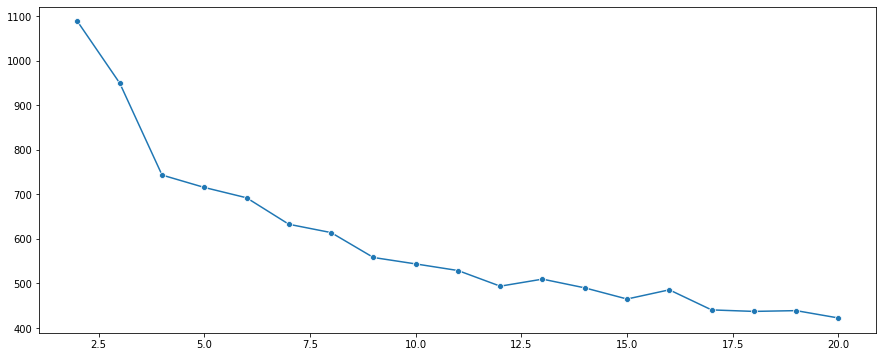

In [55]:
#plotting the curve
plt.figure(figsize=(15,6))
sns.lineplot(x=k_values,y=sse_values,marker='o')

<AxesSubplot:>

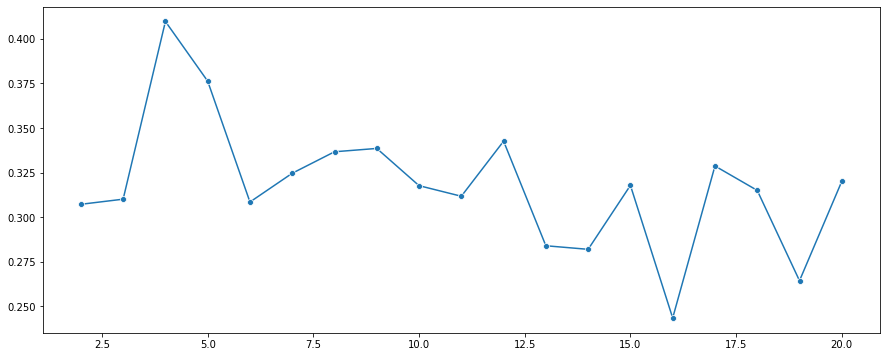

In [56]:
#plotting the curve
plt.figure(figsize=(15,6))
sns.lineplot(x=k_values,y=ss_score,marker='o')

<b>Fixing k=4</b>

## Final clustering iteration

In [57]:
k=4

In [59]:
kmeans = KMeans(featuresCol='scaledFeatures',k=k)

#fitting the model
kmeans_model = kmeans.fit(df)

#Within Set Sum of Squared Errors
wssse = kmeans_model.summary.trainingCost

# sse score
evaluator = ClusteringEvaluator(featuresCol='scaledFeatures')
ss = evaluator.evaluate(kmeans_model.summary.predictions)


print('s score',ss)
print('inertia',wssse)

s score 0.40972162431781534
inertia 743.4558688790693


In [60]:
# save k-means
kmeans_model.write().overwrite().save('./files/model_objects/kmeans/')

# 3. Profiling

We will use `.groupby()` to get cluster level summaries for profiling the clusters.

<b>Add cluster labels</b>

In [61]:
df = kmeans_model.transform(df).select('customer_id', 'prediction')
df_features = df_features.join(df, on=['customer_id'],how='left')

In [62]:
df_features.printSchema()

root
 |-- customer_id: integer (nullable = true)
 |-- sales: long (nullable = true)
 |-- qty: long (nullable = true)
 |-- orders: long (nullable = true)
 |-- unique_products_bought: long (nullable = true)
 |-- unique_payments_used: long (nullable = true)
 |-- unique_categories_bought: long (nullable = true)
 |-- aov: double (nullable = false)
 |-- aur: double (nullable = false)
 |-- upt: double (nullable = false)
 |-- A_cat_sales: double (nullable = false)
 |-- A_cat_units: double (nullable = false)
 |-- B_cat_sales: double (nullable = false)
 |-- B_cat_units: double (nullable = false)
 |-- C_cat_sales: double (nullable = false)
 |-- C_cat_units: double (nullable = false)
 |-- D_cat_sales: double (nullable = false)
 |-- D_cat_units: double (nullable = false)
 |-- E_cat_sales: double (nullable = false)
 |-- E_cat_units: double (nullable = false)
 |-- pay_cash: double (nullable = false)
 |-- pay_credit_card: double (nullable = false)
 |-- pay_debit_card: double (nullable = false)
 |-- pa

In [63]:
df_features.groupBy('prediction').count().sort('prediction').show(k)

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  293|
|         1|  284|
|         2|  194|
|         3|  229|
+----------+-----+



<b>Add *age* & *hh_income* from customer table to final features table</b>

In [64]:
df_features = df_features.join(
    df_customer.select('customer_id','age','hh_income'),
    on=['customer_id'],
    how='left')

In [65]:
# columns to aggregate for profiling
cols_to_avg = df_features.drop('customer_id','prediction').columns

<b>Overall level summary</b>

In [66]:
df_summary_o = group_by_and_rename(
    df_features,
    [],
    {'count':['customer_id'], 'avg':cols_to_avg})

df_summary_o = df_summary_o.withColumn('prediction',F.lit('overall'))
df_summary_o = df_summary_o.persist()
df_summary_o.count()

1

<b>Cluster ID level summary</b>

In [67]:
df_summary_c = group_by_and_rename(
    df_features,
    ['prediction'],
    {'count':['customer_id'], 'avg':cols_to_avg})

df_summary_c = df_summary_c.sort('prediction').persist()
df_summary_c.count()

4

<b>Save profiling table as csv</b>

We will then look at this table in excel to profile the clusters.
- All clusters can be compared to one another and to the overall dataset across all features
- Differences in features across clusters can be combined to describe each cluster
- The data used above does not have any strong differentiating markers except email subscription and omni shopper flags
- In real data you could have clusters such as *high value shoppers*, *low frequency shoppers*, or clusters showing affinity towards a single product category: *category B shoppers*, etc.

<mark>Note</mark>: You could also go back and change the number of clusters in case the profiles aren't satisfactory. There are a few parameters as well that can be changed in the kMeans model.

In [68]:
col_list = df_summary_c.columns
df_profile = df_summary_c.union(df_summary_o.select(col_list)).toPandas().T

In [69]:
df_profile.to_csv('./files/kmeans_profiling.csv')

# 4. Scoring
Once we have a k-means model trained and the clusters profiled, we can setup a scoring process that will assign cluster labels to new data.<br> This can help in tagging customers to particular clusters using latest transactions data and tracking cluster growth/movement over time.

This part of the process most likely will be done using a python script that is scheduled to run at a particular cadence instead of being done via Jupyter. You will have a code or codes that prepare the data in the required format and then a python script that uses the saved scaling and model objects to score the updated data.

In [70]:
from pyspark.ml.clustering import KMeansModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScalerModel

In [71]:
# Below process starts after the features dataset is created at customer id level
# Please have required steps done prior to this step to have the features dataset ready

# load features df
df_features = spark.read.parquet('./data/clustering_features/')

In [72]:
# fill na
df = df_features.fillna(0)

# vector assembler
vec_assembler = VectorAssembler.load('./files/model_objects/vec_assemblor/')
df = vec_assembler.transform(df)
df = df.select('customer_id','features')

# scale
scalerModel = MinMaxScalerModel.load('./files/model_objects/scaler/')
df = scalerModel.transform(df)

In [73]:
# k-means
kmeans_model = KMeansModel.load('./files/model_objects/kmeans/')

df = kmeans_model.transform(df).select('customer_id', 'prediction')

# join back
df_features = df_features.join(df, on=['customer_id'],how='left')

# save labels
df.write.parquet('./data/clustering_labels/', mode='overwrite')

In [74]:
df_features.groupBy('prediction').count().sort('prediction').show(20)

+----------+-----+
|prediction|count|
+----------+-----+
|         0|  293|
|         1|  284|
|         2|  194|
|         3|  229|
+----------+-----+

